# Introduction to Mesa Tutorial Code

This Notebook contains code corresponding to the [Intro to Mesa tutorial](http://mesa.readthedocs.org/en/tutorial_update/intro-tutorial.html), which you should check out for the full explanation and documentation.

In [1]:
# Use matplotlib for inline graphing
import matplotlib.pyplot as plt
%matplotlib inline

## Simple Model

This section corresponds to the code in the [Running Your First Model](http://mesa.readthedocs.org/en/tutorial_update/intro-tutorial.html#running-your-first-model) section of the tutorial.

First, import the base classes we'll use

In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random

Next, create the agent and model classes:

In [3]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        if self.wealth == 0:
            return
        other_agent = random.choice(model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1


In [4]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.running = True
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

Create a model and run it for 10 steps:

In [5]:
model = MoneyModel(10)
for i in range(10):
    model.step()

And display a histogram of agent wealths:

(array([ 4.,  0.,  0.,  3.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

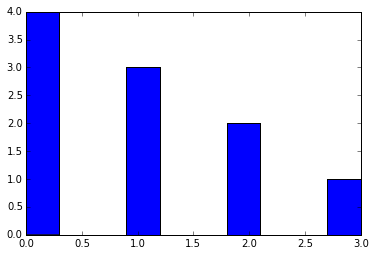

In [6]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

Create and run 100 models, and visualize the wealth distribution across all of them:

(array([ 446.,  298.,  142.,   60.,   37.,   13.,    4.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

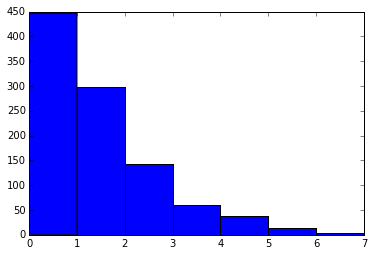

In [7]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()
    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

## Adding space

This section puts the agents on a grid, corresponding to the [Adding Space](http://mesa.readthedocs.org/en/tutorial_update/intro-tutorial.html#adding-space) section of the tutorial.

For this, we need to import the grid class:

In [8]:
from mesa.space import MultiGrid

Create the new model object. (Note that this overwrites the MoneyModel object created above)

In [9]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.running = True
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

And create the agent to go along with it:

In [10]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def move(self, model):
        possible_steps = model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = random.choice(possible_steps)
        model.grid.move_agent(self, new_position)

    def give_money(self, model):
        cellmates = model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self, model):
        self.move(model)
        if self.wealth > 0:
            self.give_money(model)

Create a model with 50 agents and a 10x10 grid, and run for 20 steps

In [11]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

Visualize the number of agents on each grid cell:

In [12]:
import numpy as np

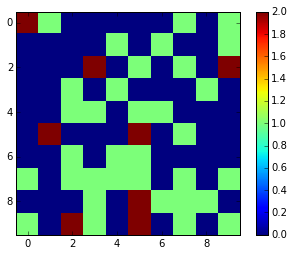

In [13]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()
 

## Collecting Data

Add a Data Collector to the model, as explained in the [corresponding section](http://mesa.readthedocs.org/en/tutorial_update/intro-tutorial.html#collecting-data) of the tutorial.

First, import the DataCollector

In [14]:
from mesa.datacollection import DataCollector

Compute the agents' [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), measuring inequality.

In [15]:
def compute_gini(model):
    '''
    Compute the current Gini coefficient.
    
    Args:
        model: A MoneyModel instance
    Returns:
        The Gini Coefficient for the model's current step.
    '''
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

This MoneyModel is identical to the one above, except for the ``` self.datacollector = ... ``` line at the end of the ```__init__``` method, and the collection in ```step```.

In [16]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.running = True
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        # New addition: add a DataCollector:
        self.datacollector = DataCollector(model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})

    def step(self):
        self.datacollector.collect(self) # Collect the data before the agents run.
        self.schedule.step()

Now instantiate a model, run it for 100 steps...

In [17]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

... And collect and plot the data it generated:

In [18]:
gini = model.datacollector.get_model_vars_dataframe()
gini.head()

,Gini
0,0.0000
1,0.3272
2,0.3944
3,0.4576
4,0.4928


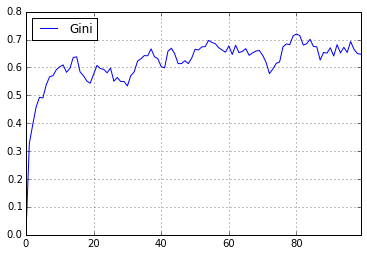

In [19]:
gini.plot()

In [20]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

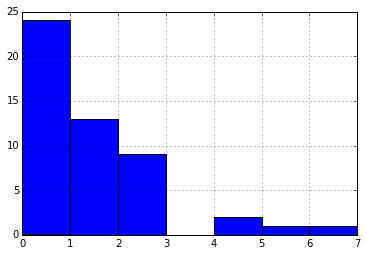

In [21]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

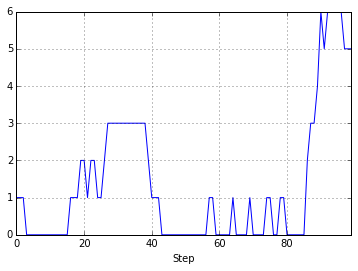

In [22]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

## Batch Run

Run a parameter sweep, as explained in the [Batch Run](http://mesa.readthedocs.org/en/tutorial_update/intro-tutorial.html#batch-run) tutorial section.

Import the Mesa BatchRunner:

In [23]:
from mesa.batchrunner import BatchRunner

Set up the batch run:

In [24]:
parameters = {"height": 10, "width": 10, "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel, parameters, iterations=5, max_steps=100,
           model_reporters={"Gini": compute_gini})

Run the parameter sweep; **this step might take a while**:

In [25]:
batch_run.run_all()

Export and plot the results:

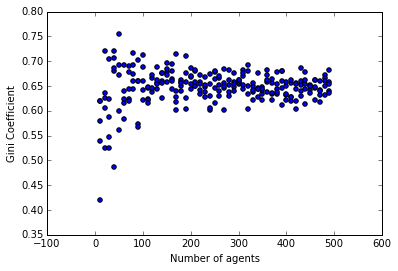

In [26]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)
plt.xlabel("Number of agents")
plt.ylabel("Gini Coefficient")

The [final tutorial section](http://mesa.readthedocs.org/en/tutorial_update/intro-tutorial.html#adding-visualization), on building and running a browser-based interactive visualization, isn't intended to be run from within a Jupyter Notebook. Shut down the notebook and follow the tutorial from there!